$$ \psi = I_\alpha (\lambda \psi^2 + \mu \psi + \nu) = I_\alpha(g)$$

We can use $\psi_t := x^\alpha N(x)$ 

https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate as integrate

In [153]:
T = 1/252
# alpha, lambd, mu, nu = 0.64, 0.045, -64.938, 44850   # EXAMPLE 1 IN THESIS
# alpha, lambd, mu, nu = 0.64, 0.2, -200, 200          # EXAMPLE 2 IN THESIS
alpha, lambd, mu, nu = 0.64, 0.8, -4, 16

In [154]:
N = nn.Sequential(nn.Linear(1, 10), nn.ELU(), nn.Linear(10,1))
Psi_t = lambda x: N(x)*x**alpha
def g(x):
    result = lambd*Psi_t(x)**2+mu*Psi_t(x)+nu
    return result
def g_ia(s,t):
    return (t-s)**(alpha-1)*g(s)

### We remind the fractional R-L integral is defined as:

$$I_\alpha g(t) = \frac{1}{\Gamma(\alpha)}\int_0^t (t-s)^{\alpha -1} g(s) ds $$

In [155]:
N = nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(),nn.Linear(10,1,bias=False))
Psi_t = lambda x: N(x)*x**alpha
def g(x):
    result = lambd*Psi_t(x)**2+mu*Psi_t(x)+nu
    return result
def g_ia(s,t):
    return (t-s)**(alpha-1)*g(s)
n_points = 50
n_legendre = 50

nodes, weights = scipy.special.roots_legendre(n_legendre)
weights_tensor = torch.tensor(weights)[:,None].float()
nodes_tensor = torch.tensor(nodes)[:,None].float()

x_train = np.linspace(0, T, n_points)[:, None]
x = torch.Tensor(x_train)
x.requires_grad = True

In [167]:
def loss(x):
    outputs = Psi_t(x)
    integrals_vector = x.double() 
    for i in range(n_points):
        if i == 0:
            integrals_vector[0][0] = 0
        else:
            t = x[i]
            transf_x_vals_tens = nodes_tensor*t/2 + t/2
            integrands_values = g_ia(transf_x_vals_tens, t)
            integral_at_time_t = 1/math.gamma(alpha)*t/2*torch.sum(integrands_values * weights_tensor)
            integrals_vector[i][0] = integral_at_time_t
    final_loss = torch.mean((outputs[1:]/(x**alpha)[1:] - integrals_vector[1:]/(x**alpha)[1:])**2)
    print('loss is', final_loss)
    return final_loss

optimizer = torch.optim.LBFGS(N.parameters(), lr=1)

def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

for i in range(5):
    optimizer.step(closure)

loss is tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)


# Comparing results with Euler

In [168]:
epsilon = 0.01  
theta = 0.9
r_max = 105

def returns_all_the_first_r_max_coefficients_as_list_2():
    ''' Run this function. This returns the list of coefficients. Up to a_k where 
        k = r_max. '''
    
    coefficients = [np.nan]*(r_max+1)

    a0 = 0 
    a1 = nu/math.gamma(alpha+1)
    coefficients[0] = a0
    coefficients[1] = a1
    
    
    def recursive_convol_coefficients(list_of_coefficients, k):
        ''' return a*_k^2  given the first k-1 a_m coefficients. 
        k is the coefficient a^_k^2 to be returned'''
        if k==1:
            return 0
        else: 
            sum = 0
            for l in range(1,k):
                a_l = list_of_coefficients[l]
                a_k_l = list_of_coefficients[k-l]
                sum += a_l*a_k_l
            return sum
    
    
    def recursive_coefficients(list_of_coefficients, n):
        ''' Given the convoluted coefficient a_k_star_quadro, 
        Given also n, the coefficient a_n to be returned... Note that n = k+1 !!! 
        returns a_k'''
        k = n-1 # n-1 = k
        a_k_star_quadro = recursive_convol_coefficients(list_of_coefficients, k) 
        a_k = list_of_coefficients[k]  
        a_n = (lambd*a_k_star_quadro + mu*a_k)*math.gamma(alpha*k + 1)/math.gamma(alpha*k + alpha + 1)
    
        return a_n

    for i in range(2, r_max+1):
        coefficients[i] = recursive_coefficients( coefficients, i)
        
    return coefficients

coeff = returns_all_the_first_r_max_coefficients_as_list_2()

coeff_df = pd.DataFrame(coeff)

a_r_max = coeff[-1]
a_primo_r_max = a_r_max*math.gamma(alpha*r_max+1)/(math.gamma(alpha*r_max-alpha+1)*(alpha*r_max+1-alpha))

R_estimate = abs(a_primo_r_max)**(-1/(alpha*r_max))

r_0 = math.log(epsilon*(1-theta))/alpha/math.log(theta)-1
r_0 = int(np.round(r_0)+1)

slicing = slice(0,r_0)

coeff_truncated = coeff[slicing]

def poly(lst, x):   
    ''' Evaluate the polynomial with coefficients lst= [a0,a1,a2,...] in x
    Pol: a0 + a1*x**alpha + a2*x**(2*alpha) + .... '''
    n, tmp = 0, 0
    for a in lst:
        tmp = tmp + (a * (x**(n*alpha)))
        n += 1

    return tmp

def computing_psi_n(n):
    ''' Just Give n. This function makes use of the parameters. Then also of the list "coeff_truncated" 
    '''
    
    disc_times = [k*T/n for k in range(0,n+1)]
    
    theta = 0.9
    #theta = theta_n(n) # Only In This Example, Because The Theta fixed at the beginning would go out otherwise!
    
    
    
    k_0 = math.floor(R_estimate*theta*n/T)  ### Up to t_k_0 we will use truncated series. Then Euler Schema
    
    if k_0 >= len(disc_times):
        t_k_0 = "Doesn't exist t_k_0"
    else: 
        t_k_0 = disc_times[k_0]
    
    values_assumed_in_disc_times = [np.nan]*(n+1)
    

    
    
    ### Here We Evaluate The Truncated Series!
    
    if k_0 <= len(disc_times):
        for k in range(0,k_0+1):
            values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    else:
        for k in range(0,n):
            values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    
    
    
    
    ### Here Instead We Use The Euler Scheme
    def compute_c_i(alpha, l):
        if l == 0:
            return 1
        else: 
            return (l+1)**alpha - l**alpha
    
    
    
    for k in range(k_0+1, n+1):
        factor_1 = 1/math.gamma(alpha + 1)*(T/n)**alpha
        addend_2 = nu*k**alpha 
        addend_3 = 0
        for l in range(1,k):
            psi_n_t_l = values_assumed_in_disc_times[l]
            addend_3 += compute_c_i(alpha, k-l-1)*psi_n_t_l*(lambd*psi_n_t_l + mu)
        
        factor_2 = addend_2 + addend_3
        
        result = factor_1*factor_2
        
        values_assumed_in_disc_times[k] = result
            
    
    print("t_k0=", t_k_0)
    
    #return disc_times, values_assumed_in_disc_times
    return pd.DataFrame({"time": disc_times, "value": values_assumed_in_disc_times}), t_k_0

In [169]:
coeff_df

,0
0,0.000000e+00
1,1.780464e+01
2,-5.551124e+01
3,2.948234e+02
4,-1.445304e+03
...,...
101,3.493067e+75
102,-1.963249e+76
103,1.103465e+77
104,-6.202353e+77


In [170]:
R_estimate

0.06934699916171216

In [171]:
T

0.003968253968253968

In [172]:
r_0

102

In [173]:
comparison = computing_psi_n(1028)

t_k0= Doesn't exist t_k_0


In [174]:
results_euler_scheme = comparison[0]

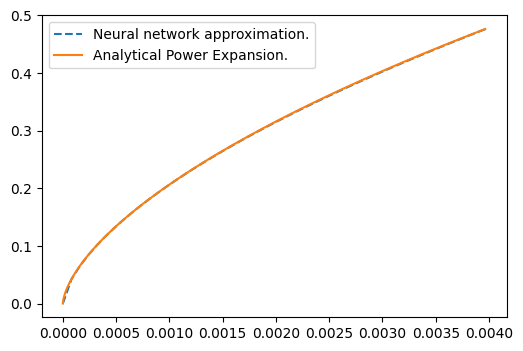

In [179]:
fig, ax = plt.subplots(dpi=100)
xx = x.tolist()
yy = (Psi_t(x)[:,0]).tolist()
# yt = Psi_real(x).tolist()
ax.plot(xx, yy, "--",  label='Neural network approximation.')
ax.plot(results_euler_scheme.time, results_euler_scheme.value, label='Analytical Power Expansion.')

ax.legend(loc="best")

if type(comparison[1]) == type(2.0):
    ax.axvline(x = comparison[1], linewidth=1, color='r')